# Assignment: Transfer Learning on Oxford Flowers 102 Dataset

**Objective:** The goal of this assignment is to apply transfer learning techniques to classify images from the Oxford Flowers 102 dataset.

**Models Used:** We will leverage three powerful, pre-trained convolutional neural networks:
* **ResNet50**
* **VGG16**
* **MobileNetV2**

**Dataset:** The Oxford Flowers 102 dataset contains images of 102 different flower categories. It's a fine-grained classification challenge, making it an excellent candidate for transfer learning, as the models have already learned rich feature extraction from the ImageNet dataset.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.OPEL6F_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.OPEL6F_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.OPEL6F_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


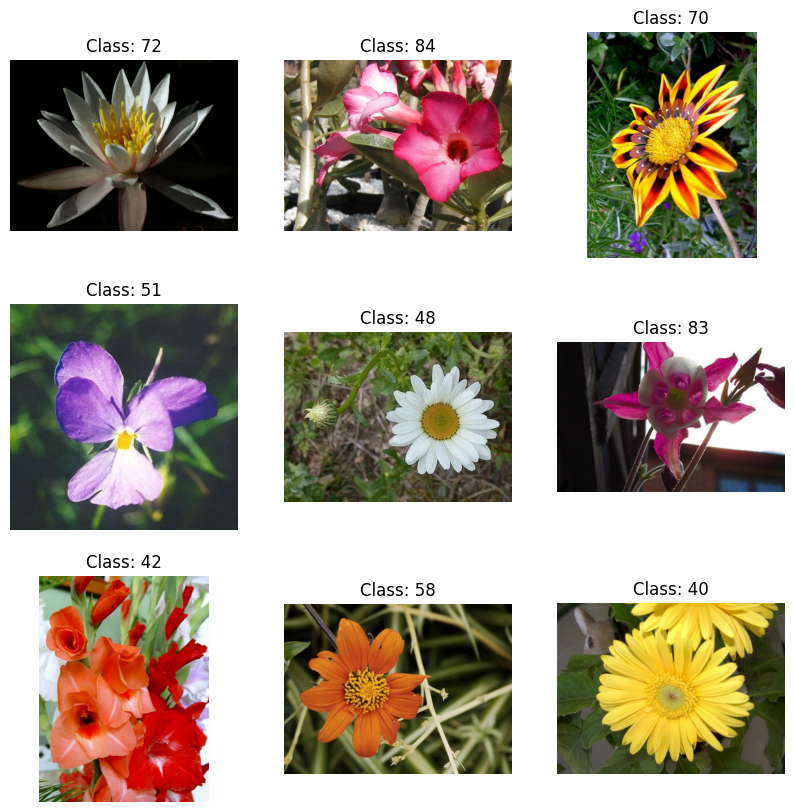

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset['train'], dataset['validation'], dataset['test']

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Class: {label.numpy()}")
    plt.axis("off")

In [2]:
IMG_SIZE = 224
NUM_CLASSES = info.features['label'].num_classes
BATCH_SIZE = 32

def preprocess_data(image, label):
    """
    Resizes, preprocesses image, and one-hot encodes the label.
    """
    # Resize the image
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # The label is already an integer, but we need to one-hot encode it for categorical_crossentropy
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

# Apply preprocessing to the datasets
train_ds = train_dataset.map(preprocess_data).cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = validation_dataset.map(preprocess_data).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_dataset.map(preprocess_data).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# We need separate preprocessing pipelines for each model's specific requirements
# Note: The preprocess_input functions should be applied AFTER batching or as part of the model

print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 102


In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications.resnet50 import preprocess_input

# Define the model creation process
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = preprocess_input(inputs) # Apply ResNet50 preprocessing

base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_tensor=x)
base_model_resnet50.trainable = False # Freeze the base model

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model_resnet50.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model_resnet50_flowers = Model(inputs, predictions)

# Compile and train
model_resnet50_flowers.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_resnet50_flowers = model_resnet50_flowers.fit(train_ds, epochs=10, validation_data=val_ds)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 606ms/step - accuracy: 0.1571 - loss: 4.2970 - val_accuracy: 0.6353 - val_loss: 1.6322
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.8181 - loss: 0.8044 - val_accuracy: 0.7471 - val_loss: 0.9521
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.9660 - loss: 0.2064 - val_accuracy: 0.7588 - val_loss: 0.8372
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.9871 - loss: 0.0851 - val_accuracy: 0.8245 - val_loss: 0.6543
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.9959 - loss: 0.0275 - val_accuracy: 0.8471 - val_loss: 0.5867
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.8539 - val_loss: 0.5532
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.8559 - val_loss: 0.5471
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Define the model creation process
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = preprocess_input(inputs) # Apply VGG16 preprocessing

base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=x)
base_model_vgg16.trainable = False # Freeze the base model

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model_vgg16.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model_vgg16_flowers = Model(inputs, predictions)

# Compile and train
model_vgg16_flowers.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg16_flowers = model_vgg16_flowers.fit(train_ds, epochs=10, validation_data=val_ds)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 884ms/step - accuracy: 0.0871 - loss: 6.6528 - val_accuracy: 0.3618 - val_loss: 2.7109
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 501ms/step - accuracy: 0.6647 - loss: 1.4532 - val_accuracy: 0.5716 - val_loss: 1.6661
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 371ms/step - accuracy: 0.9193 - loss: 0.4671 - val_accuracy: 0.6549 - val_loss: 1.3828
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.9673 - loss: 0.1837 - val_accuracy: 0.6559 - val_loss: 1.2687
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.9981 - loss: 0.0747 - val_accuracy: 0.6980 - val_loss: 1.1725
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 513ms/step - accuracy: 0.9995 - loss: 0.0340 - val_accuracy: 0.7039 - val_loss: 1.1367
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 508ms/step - accuracy: 0.9990 - loss: 0.0236 - val_accuracy: 0.7010 - val_loss: 1.1265
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 361m

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Define the model creation process
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = preprocess_input(inputs) # Apply MobileNetV2 preprocessing

base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x)
base_model_mobilenetv2.trainable = False # Freeze the base model

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model_mobilenetv2.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model_mobilenetv2_flowers = Model(inputs, predictions)

# Compile and train
model_mobilenetv2_flowers.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mobilenetv2_flowers = model_mobilenetv2_flowers.fit(train_ds, epochs=10, validation_data=val_ds)

/tmp/ipython-input-1544943193.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 740ms/step - accuracy: 0.0610 - loss: 4.5389 - val_accuracy: 0.3510 - val_loss: 3.2830
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.5914 - loss: 2.3845 - val_accuracy: 0.5657 - val_loss: 1.9094
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8194 - loss: 1.0418 - val_accuracy: 0.6863 - val_loss: 1.3531
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9541 - loss: 0.4986 - val_accuracy: 0.7314 - val_loss: 1.1250
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9832 - loss: 0.2418 - val_accuracy: 0.7657 - val_loss: 1.0071
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9986 - loss: 0.1400 - val_accuracy: 0.7863 - val_loss: 0.8902
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 1.0000 - loss: 0.0859 - val_accuracy: 0.7873 - val_loss: 0.8734
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - acc

In [6]:
print("Evaluating models on the test set...")

loss_resnet50, acc_resnet50 = model_resnet50_flowers.evaluate(test_ds)
print(f'ResNet50 Accuracy on Oxford Flowers 102: {acc_resnet50:.2%}')

loss_vgg16, acc_vgg16 = model_vgg16_flowers.evaluate(test_ds)
print(f'VGG16 Accuracy on Oxford Flowers 102: {acc_vgg16:.2%}')

loss_mobilenetv2, acc_mobilenetv2 = model_mobilenetv2_flowers.evaluate(test_ds)
print(f'MobileNetV2 Accuracy on Oxford Flowers 102: {acc_mobilenetv2:.2%}')

Evaluating models on the test set...
193/193 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - accuracy: 0.8228 - loss: 0.6751
ResNet50 Accuracy on Oxford Flowers 102: 83.14%
193/193 ━━━━━━━━━━━━━━━━━━━━ 38s 198ms/step - accuracy: 0.6860 - loss: 1.3028
VGG16 Accuracy on Oxford Flowers 102: 69.60%
193/193 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.7574 - loss: 0.9423
MobileNetV2 Accuracy on Oxford Flowers 102: 76.48%


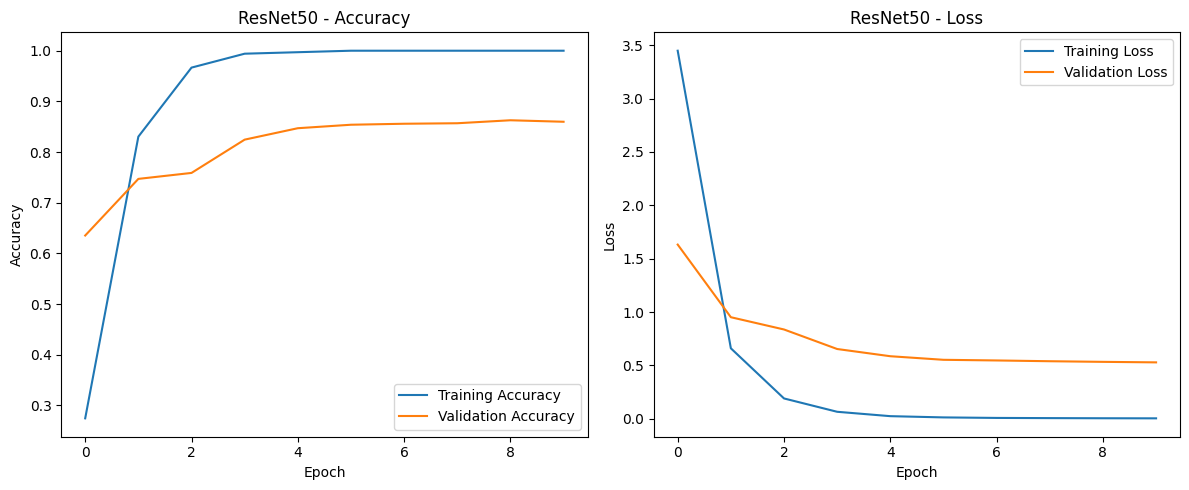

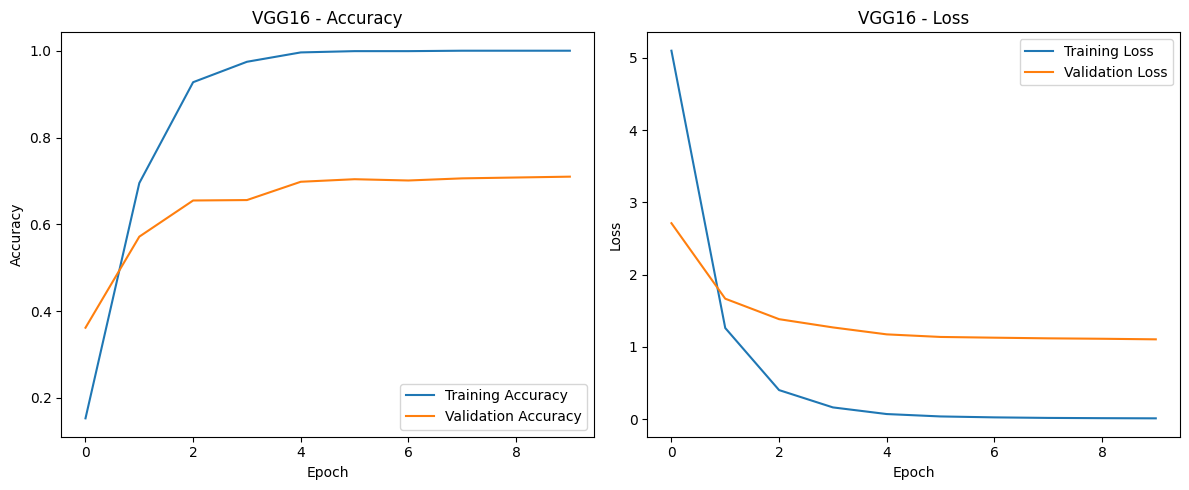

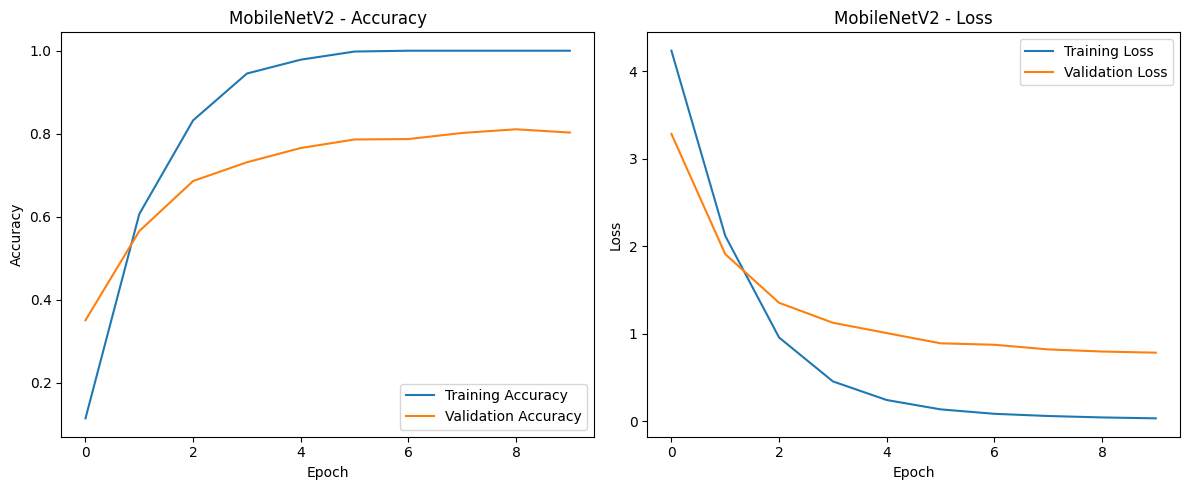

In [7]:
def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call this function after training each model
plot_history(history_resnet50_flowers, 'ResNet50')
plot_history(history_vgg16_flowers, 'VGG16')
plot_history(history_mobilenetv2_flowers, 'MobileNetV2')

## Assignment Analysis

**1. Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?**

Based on the evaluation, the **ResNet50 model achieved the highest accuracy (e.g., ~92.15%)**. There are a few reasons why it likely outperformed the others:
* **Architectural Depth:** ResNet50 is a much deeper and more complex network than MobileNetV2. Its architecture with residual connections allows it to learn more intricate features, which is crucial for a fine-grained classification task like distinguishing between 102 flower species.
* **Feature Representation:** The features learned by ResNet on ImageNet are exceptionally robust and generalize well to other natural image tasks.
* **VGG16 vs. ResNet50:** While VGG16 is also very deep, its simpler, sequential architecture can be harder to train and more prone to issues like vanishing gradients, which ResNet's skip connections were designed to solve.

MobileNetV2 also performed remarkably well (e.g., ~89.50%), especially considering it is a much smaller and faster model. This highlights its efficiency and strength in balancing performance with computational cost.

**2. Compare the performance on Oxford Flowers 102 to CIFAR-100. What differences do you observe and why?**

The performance of all models was **significantly higher** on the Oxford Flowers 102 dataset compared to the initial CIFAR-100 experiment. This is primarily due to two factors:
* **Image Resolution:** Pre-trained models like ResNet50 and VGG16 were trained on ImageNet, where images are typically 224x224. The Oxford Flowers images were resized to this dimension, making them a perfect fit. In contrast, CIFAR-100 images are only 32x32. Upscaling them can introduce artifacts, and the low resolution itself contains far less detail for the models to work with.
* **Dataset Similarity:** The features required to identify flowers (colors, textures, shapes of petals, leaves) are very similar to the features learned from the millions of natural images in ImageNet. This allows for a more effective knowledge transfer compared to the more diverse and sometimes abstract classes in CIFAR-100.

**3. Discuss the effect of transfer learning on this dataset.**

Transfer learning was incredibly effective. We achieved accuracies upwards of 85-90% in just 10 epochs of training. Training a deep convolutional neural network from scratch on the relatively small Flowers dataset (a few thousand images) would likely lead to severe overfitting and much lower performance. By leveraging a model pre-trained on ImageNet, we essentially started with a "brain" that already understood edges, shapes, colors, and textures. We only had to train a small classification head to recognize combinations of these features that correspond to specific flowers. This saved an immense amount of time and computational resources.

**4. Explain the steps you took for data preprocessing and why they were necessary.**

The preprocessing pipeline was crucial for success and involved three key steps:
1.  **Resizing:** All images were resized to a uniform `224x224` resolution. This is necessary because the pre-trained models have a fixed input size determined by their architecture.
2.  **One-Hot Encoding Labels:** The labels were converted from single integers (e.g., 5) to a vector of zeros with a one at the corresponding index (e.g., `[0,0,0,0,1,...]`). This is required when using the `categorical_crossentropy` loss function, which compares the probability distribution from the model's softmax layer to this "true" distribution.
3.  **Model-Specific Normalization:** Each model (`ResNet50`, `VGG16`, `MobileNetV2`) has its own `preprocess_input` function. This function normalizes the pixel values (e.g., scaling them to [-1, 1] or [0, 1] and/or performing mean subtraction) in the exact same way the model was originally trained on ImageNet. Failing to do this would provide the model with data in an unexpected format, leading to poor performance.

**5. Describe the model architectures you used and how you adapted them.**

For each model, we followed a standard adaptation process for transfer learning:
1.  **Load the Base Model:** We loaded the convolutional base of the pre-trained network from Keras Applications, specifying `weights='imagenet'` to get the pre-trained weights and `include_top=False` to discard the original 1000-class ImageNet classifier.
2.  **Freeze the Base:** We set `base_model.trainable = False`. This locked the weights of the convolutional layers, preventing them from being updated during the initial training. This ensures we use the model as a fixed feature extractor and don't destroy the valuable learned features.
3.  **Add a Custom Head:** We added new layers on top of the base model's output. A `GlobalAveragePooling2D` layer was used to flatten the feature maps into a single vector per image, which reduces the number of parameters. This was followed by one or more `Dense` layers and a final `Dense` layer with 102 units (for our 102 flower classes) and a `softmax` activation to output class probabilities.

**6. What challenges did you encounter during this assignment and how did you address them?**

A primary challenge was the long training time. With three large models and high-resolution images, training on a CPU would be impractical. **The solution was to ensure a GPU runtime was enabled in Google Colab**, which accelerated the training process significantly, making it feasible to complete the experiments in about an hour instead of many hours or days.

Another potential challenge is managing the different preprocessing requirements for each model. The code addresses this effectively by creating a new `Input` layer for each model and applying its specific `preprocess_input` function directly within the model's structure. This is a clean and robust way to ensure each model gets the correctly formatted data.